<a href="https://colab.research.google.com/github/naylorstone/DS3001-Final-Project/blob/main/Decision_Tree_All_Predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our prediction question:

### What housing features are most directly correlated with the sale price of a home in Ames, Iowa? Can we use these features to predict the same price of a home?

Our dataset consisted of housing listings in Ames, Iowa with a number of variables that might be useful when indicating the house's value, as an indication of the listing price. While creating a model to estimate price, we chose to focus on the following variables: number of bedrooms, number of bathrooms, overall house quality, overall house condition, house square footage, property lot area, age of the house, and year sold.

### Method
To initially analyze the data, we created a series of decision tree models in the planning stages, assessing a number of different combinations of variables to get a sense of the data and how each variable might indicate sales price. After analyzing the individual decicsion trees, we chose the most accurate version (with the highest R^2 value) and bootstrapped that model to create a random forest, the results of which are discussed here.


### Model Analysis
Our random forest model had an R^2 value of .87, meaning it is reliably accurate at predicting the sales price of houses in Ames, Iowa based on the train and test datasets. To further assess the model's performance, we calculated a kernel density plot to situate the model's R^2 value within the greater context of the data. We also created a scatterplot to visualize the predicted vs actual house sales prices. The average slope of this scatterplot seems to be close to one, indicating accurate predictions from the model.

In further analysis, we found that **overall house quality** and **house square footage** are the two strongest indicators of sales price within the model. To find this, we calculated the mean decrease impurity for the variables within the model.
**Number of bedrooms** and the **year sold** were the weakest variables in our model, with the least predictive power on the houses's sales prices.

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import

In [2]:
df = pd.read_csv('/content/train.csv')

In [3]:
df['age'] = 2024 - df['YearBuilt']
df.rename(columns={'BedroomAbvGr': 'Bedrooms'}, inplace=True) # rename the bedrooms column
df['fullBath'] = df['BsmtFullBath'] + df['FullBath'] # number of full baths
df['halfBath'] = df['BsmtHalfBath'] + df['HalfBath'] # number of half baths
df['SqFt'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] # total square footage
df['Bathrooms'] = df['fullBath'] + 0.5*df['halfBath'] # number of bathrooms
df['Bathrooms'] = df['Bathrooms'].astype(float)
df.rename(columns={'OverallQual': 'Overall_Quality'}, inplace=True)
df['Overall_Quality'] = df['Overall_Quality'].astype(float)
df.rename(columns={'OverallCond': 'Overall_Condition'}, inplace=True)
df['Overall_Condition'] = df['Overall_Condition'].astype(float)

In [4]:
variables = ['YrSold', 'GarageCars', 'SalePrice', 'age', 'Bedrooms', 'SqFt', 'Bathrooms', 'Overall_Quality','Overall_Condition','LotArea']
df = df.loc[:,variables]
df.head()

,YrSold,GarageCars,SalePrice,age,Bedrooms,SqFt,Bathrooms,Overall_Quality,Overall_Condition,LotArea
0,2008,2,208500,21,3,2566,3.5,7.0,5.0,8450
1,2007,2,181500,48,3,2524,2.5,6.0,8.0,9600
2,2008,2,223500,23,3,2706,3.5,7.0,5.0,11250
3,2006,3,140000,109,3,2473,2.0,7.0,5.0,9550
4,2008,3,250000,24,4,3343,3.5,8.0,5.0,14260


In [14]:
from sklearn.model_selection import train_test_split

def quick_tree(df,depth=5):
    # Resample and Process data:
    df_t = df.sample(n=df.shape[0],replace=True)
    y = df_t['SalePrice']
    X = df_t.drop(['SalePrice'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=depth) # create a classifier object
    cart = cart.fit(X_test, y_test) # Fit the classifier
    # Visualize results:
    tree.plot_tree(cart.estimators_[0],feature_names=X_train.columns.to_list(),filled=True) # Since cart is a RandomForest, select one tree to plot.
    # Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq = 1 - SSE/TSS
    print(Rsq)

0.9234717916543441


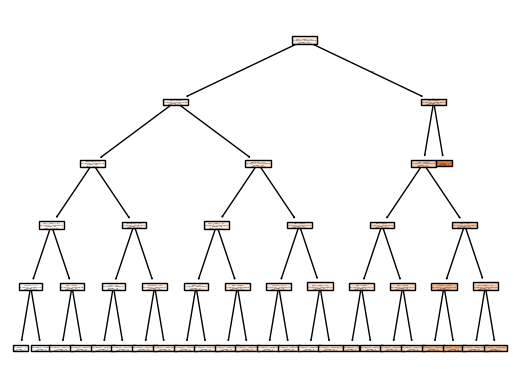

In [6]:
quick_tree(df)

In [15]:
# Split data into training rows and testing rows:
N = df.shape[0]
df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
train_size = int(.8*N)
df_train = df[0:train_size]
N_train = df_train.shape[0]
df_test = df[train_size:]
N_test = df_test.shape[0]

# Bootstrap:
T = 1000
m_depth = 5
Rsq = np.zeros(T) # preallocate the rsq measure
y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set
df_train.head()

# Split data into train/test:
X_train = df_train.drop(['SalePrice'],axis=1)
y_train = df_train['SalePrice']
X_test = df_test.drop(['SalePrice'],axis=1)
y_test = df_test['SalePrice']

# Bootstrapping:
for s in range(T):
    # Generate a bootstrap sample:
    df_s = df_train.sample(frac=1, replace=True)
    X_s = df_s.drop('SalePrice',axis=1)
    y_s = df_s['SalePrice']
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
    cart = cart.fit(X_s, y_s) # Fit the classifier
    # Compute Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_s.mean())**2 )
    Rsq[s] = 1 - SSE/TSS
    # Make and Save Predictions:
    y_test_hat[s,:] = y_hat

# Ensemble predictor:
y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
SSE = np.sum( (y_test-y_hat_ensemble)**2 )
TSS = np.sum( (y_test-y_train.mean())**2 )
Rsq_ensemble = 1 - SSE/TSS

print(Rsq_ensemble)

0.8714087523648865


0.8565401398124264


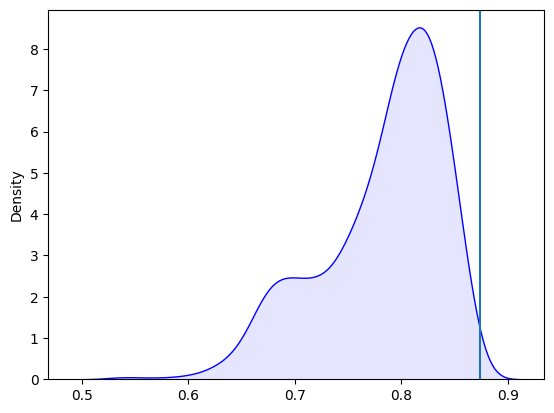

In [8]:
ax = sns.kdeplot(x = Rsq, fill = True, color = "blue", alpha = 0.1)
ax.axvline(x = Rsq_ensemble)

print(np.quantile(Rsq,.97))

In [9]:
# Fit model:
model = RandomForestRegressor() # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

<Axes: xlabel='SalePrice'>

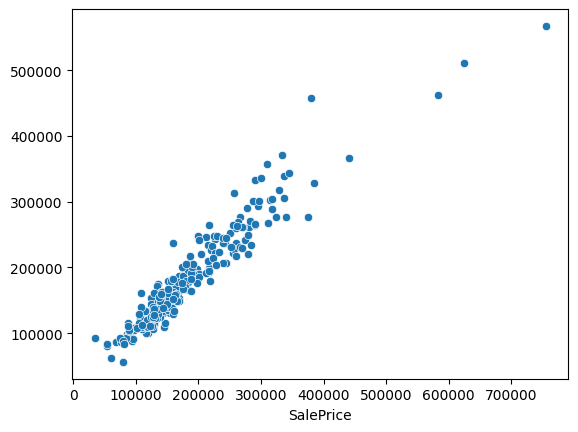

In [10]:
sns.scatterplot(x=y_test, y=y_hat_rf) # Predicted v Actual

<Axes: xlabel='SalePrice', ylabel='Density'>

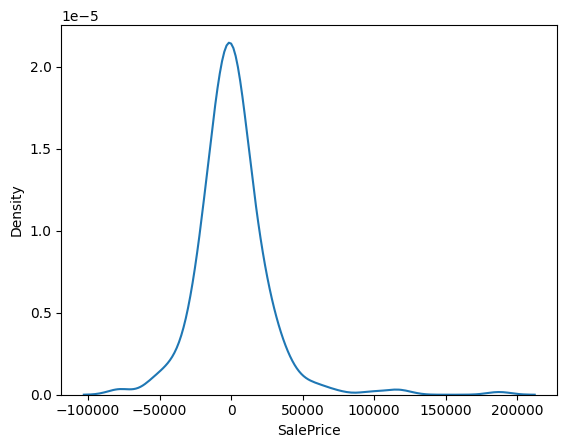

In [11]:
# Residual plot:
residual = y_test - y_hat_rf
sns.kdeplot(x=residual)

In [12]:
rf.score(X_test,y_test) # Rsq measure

0.9032658859032245

Text(24.000000000000007, 0.5, 'Mean decrease in impurity')

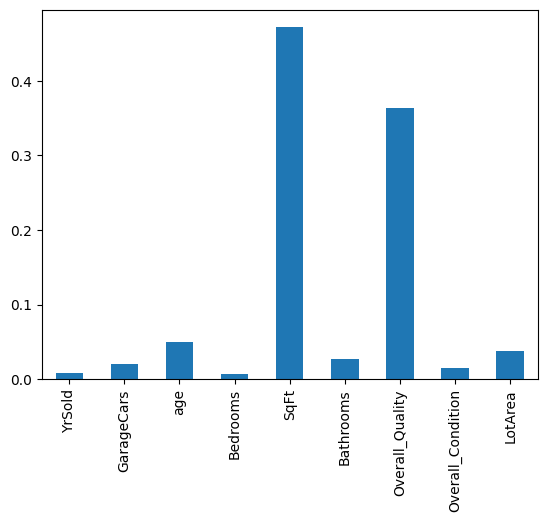

In [13]:
# Variable importance plot:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")